<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/Guilherme_Pereira/Aula_4_Guilherme_Pereira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

import math
import torchvision.transforms.functional as F

## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [5]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [10]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

class DataLoader():
  def __init__(self, dataset, batch_size, shuffle):

    self.dataset    = dataset
    self.batch_size = batch_size
    self.order      = torch.randperm(len(dataset)) if shuffle else torch.tensor(range(len(dataset)))    

    self.x, self.y = list(zip(*list(self.dataset)))
    self.x = torch.cat(self.x)
    self.y = torch.tensor(self.y)

    self.number_batch = math.ceil(len(self.dataset) / self.batch_size)
    

  def __len__(self): 
    
    return self.number_batch

  def __iter__(self):

    self.data_idx = 0
    return self
  
  def __next__(self):

    if self.data_idx < self.__len__():

      x = self.x[self.data_idx*self.batch_size: (self.data_idx + 1) * self.batch_size]
      y = self.y[self.data_idx*self.batch_size: (self.data_idx + 1) * self.batch_size]
      batch = (x, y)
      
      self.data_idx += 1

      return batch
    else:
      raise StopIteration

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [11]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [14]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

class LinearModel():

  def __init__(self, in_layer, out_layer):

    self.w = torch.zeros(size=(in_layer, out_layer), requires_grad=True)
    self.b = torch.zeros((1, out_layer), requires_grad=True)

  def forward(self, x):
    return x @ self.w + self.b

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    return [self.w, self.b]

model = LinearModel(28*28, 10)

## Treinamento

### Inicialização dos parâmetros

In [17]:
n_epochs = 50
lr = 0.1

## Definição da Loss



In [15]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

import torch.nn.functional as f

class CrossEntropyLoss(torch.nn.Module):
  def __init__(self):
    
    super(CrossEntropyLoss, self).__init__()

  def forward(self, y_pred, y):

    softmax = f.softmax(y_pred)
    one_hot = torch.eye(y_pred.shape[-1])[y]
    
    target_softmax = (one_hot*softmax).sum(1)

    return -1*torch.log(target_softmax).mean()

criterion = CrossEntropyLoss()

# Definição do Optimizer

In [18]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

class SGD():
    def __init__(self, parameters, lr: float):

        self.parameters    = parameters
        self.learning_rate = lr

    def step(self):

        for parameter in self.parameters:
            parameter.data -= (self.learning_rate * parameter.grad).detach()

    def zero_grad(self):

        for parameter in self.parameters:
            parameter.grad = torch.zeros(parameter.data.shape)

optimizer = SGD(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [19]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786613464355
Epoch: 3/49 Loss: 0.6381281614303589
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.47862711548805237
Epoch: 8/49 Loss: 0.4558936655521393
Epoch: 9/49 Loss: 0.43632182478904724
Epoch: 10/49 Loss: 0.4191650450229645
Epoch: 11/49 Loss: 0.4039044976234436
Epoch: 12/49 Loss: 0.3901680111885071
Epoch: 13/49 Loss: 0.3776799440383911
Epoch: 14/49 Loss: 0.36623141169548035
Epoch: 15/49 Loss: 0.35566139221191406
Epoch: 16/49 Loss: 0.34584277868270874
Epoch: 17/49 Loss: 0.33667412400245667
Epoch: 18/49 Loss: 0.32807353138923645
Epoch: 19/49 Loss: 0.31997358798980713
Epoch: 20/49 Loss: 0.312318354845047
Epoch: 21/49 Loss: 0.3050611615180969
Epoch: 22/49 Loss: 0.29816246032714844
Epoch: 23/49 Loss: 0.29158854484558105
Epoch: 24/49 Loss: 0.28531038761138916
Epoch: 25/49 Loss: 0.2793029844760895
Epoch: 26/49 

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

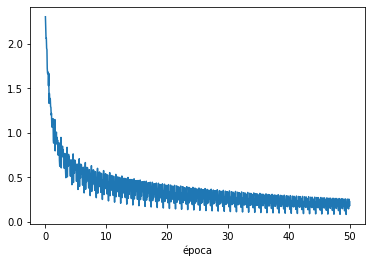

In [20]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

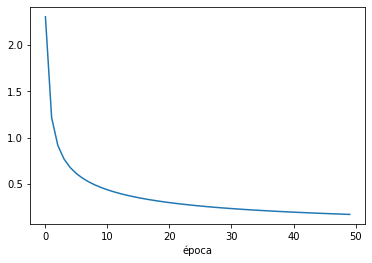

In [21]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [22]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

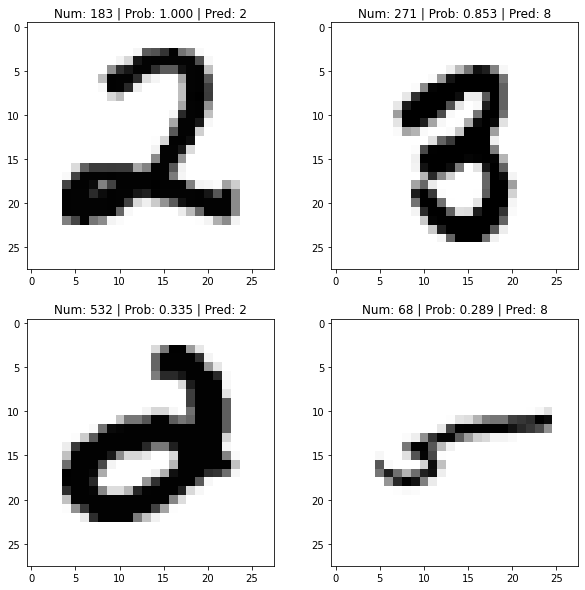

In [52]:
# Escreva o código aqui:

loader_train = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False) 

x, y = next(iter(loader_train))

x       = x.view(x.shape[0], -1)
y_pred  = model(x)
softmax = torch.exp(y_pred)/torch.sum(torch.exp(y_pred), dim=1, keepdim=True)

predict      = torch.argmax(softmax, axis=1)
predict_prob = torch.max(softmax, axis=1)[0]

true_pred  = torch.where(predict == y, predict_prob, torch.tensor((0.5,))[0])
false_pred = torch.where(predict != y, predict_prob, torch.tensor((0.5,))[0])


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

ax1.imshow(x[torch.argmax(true_pred)].numpy().reshape(28,28), cmap='Greys')
ax2.imshow(x[torch.argmax(false_pred)].numpy().reshape(28,28), cmap='Greys')
ax3.imshow(x[torch.argmin(true_pred)].numpy().reshape(28,28), cmap='Greys')
ax4.imshow(x[torch.argmin(false_pred)].numpy().reshape(28,28), cmap='Greys')

ax1.set_title(f"Num: {torch.argmax(true_pred)} | Prob: {torch.max(true_pred):.3f} | Pred: {predict[torch.argmax(true_pred)]}")
ax2.set_title(f"Num: {torch.argmax(false_pred)} | Prob: {torch.max(false_pred):.3f} | Pred: {predict[torch.argmax(false_pred)]}")
ax3.set_title(f"Num: {torch.argmin(true_pred)} | Prob: {torch.min(true_pred):.3f} | Pred: {predict[torch.argmin(true_pred)]}")
ax4.set_title(f"Num: {torch.argmin(false_pred)} | Prob: {torch.min(false_pred):.3f} | Pred: {predict[torch.argmin(false_pred)]}")

plt.show()


## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.
